## Notebook based on transfer_learn.py
* used a notebook so that i can store the outputs and screenshot them whenever required

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
import time
import os
import copy
from sklearn.metrics import confusion_matrix
from utils import cf_matrix
import seaborn as sns


### data preprocessing

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


### dataloaders

In [3]:
data_dir = './data/hyphaAug'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          transform=data_transforms[x])
                                        # transform=transforms.ToTensor())
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names) # contam, no_contam

['contam', 'no_contam']


In [4]:
# obtain initial shape
img, label = image_datasets['test'][8]
print(f"initial image shape: {img.shape} ")
print(f"label: {label} ")
print(len(image_datasets['train']))
print(len(image_datasets['test'])) # 52
print(len(image_datasets['train'].targets))
print(img)

initial image shape: torch.Size([3, 256, 256]) 
label: 0 
205
52
205
tensor([[[-1.7647, -1.7647, -1.7647,  ...,  0.7922,  0.7137,  0.6980],
         [-1.7647, -1.7647, -1.7647,  ...,  0.8235,  0.7451,  0.7294],
         [-1.7647, -1.7647, -1.7647,  ...,  0.9490,  0.9020,  0.9020],
         ...,
         [-1.8902, -1.8902, -1.8902,  ..., -1.8902, -1.8902, -1.8902],
         [-1.8902, -1.8902, -1.8902,  ..., -1.8902, -1.8902, -1.8902],
         [-1.8902, -1.8902, -1.8902,  ..., -1.8902, -1.8902, -1.8902]],

        [[-1.7647, -1.7647, -1.7647,  ...,  0.7137,  0.6667,  0.6510],
         [-1.7647, -1.7647, -1.7647,  ...,  0.7451,  0.6980,  0.6824],
         [-1.7647, -1.7647, -1.7647,  ...,  0.8706,  0.8392,  0.8392],
         ...,
         [-1.8902, -1.8902, -1.8902,  ..., -1.8745, -1.8745, -1.8745],
         [-1.8902, -1.8902, -1.8902,  ..., -1.8745, -1.8745, -1.8745],
         [-1.8902, -1.8902, -1.8902,  ..., -1.8745, -1.8745, -1.8745]],

        [[-1.7333, -1.7333, -1.7333,  ...,  0.4

### look at my images

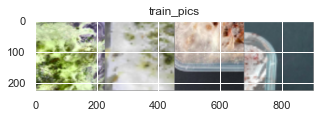

In [20]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

# show training data

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, "train_pics")

### train loop

In [21]:
# need them for plotting
epoch_train_loss = []
epoch_train_accuracy = []
epoch_val_accuracy = []
epoch_val_loss = []

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                epoch_train_loss.append(epoch_loss)
                epoch_train_accuracy.append(epoch_acc)

            if phase == 'test':
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                epoch_val_loss.append(epoch_loss)
                epoch_val_accuracy.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [23]:
# need them for plotting
epoch_train_loss = []
epoch_train_accuracy = []
epoch_val_accuracy = []
epoch_val_loss = []

### transfer learning

In [76]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet50(pretrained=True)
# freeze 
for param in model_conv.parameters():
    param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


### train model

In [77]:
# path =  'models_trained/resnet18_hyphaAug4.pth'
path =  'models_trained/resnet50_hyphaAug1.pth'

In [78]:
# train loop
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

torch.save(model_conv, path)
print(f"model saved at path {path}")

Epoch 0/9
----------
train Loss: 0.5487 Acc: 0.7122
test Loss: 0.3600 Acc: 0.7885

Epoch 1/9
----------
train Loss: 0.5198 Acc: 0.7610
test Loss: 0.3245 Acc: 0.8462

Epoch 2/9
----------
train Loss: 0.4657 Acc: 0.7951
test Loss: 0.3767 Acc: 0.8269

Epoch 3/9
----------
train Loss: 0.4473 Acc: 0.8195
test Loss: 0.2938 Acc: 0.8462

Epoch 4/9
----------
train Loss: 0.4381 Acc: 0.8293
test Loss: 0.5710 Acc: 0.7692

Epoch 5/9
----------
train Loss: 0.3776 Acc: 0.8439
test Loss: 0.2710 Acc: 0.8846

Epoch 6/9
----------
train Loss: 0.4757 Acc: 0.7951
test Loss: 0.5639 Acc: 0.7500

Epoch 7/9
----------
train Loss: 0.3331 Acc: 0.8732
test Loss: 0.2099 Acc: 0.8846

Epoch 8/9
----------
train Loss: 0.3249 Acc: 0.8780
test Loss: 0.2868 Acc: 0.8462

Epoch 9/9
----------
train Loss: 0.2661 Acc: 0.8683
test Loss: 0.2615 Acc: 0.8654

Training complete in 3m 59s
Best val Acc: 0.884615
model saved at path models_trained/resnet50_hyphaAug1.pth


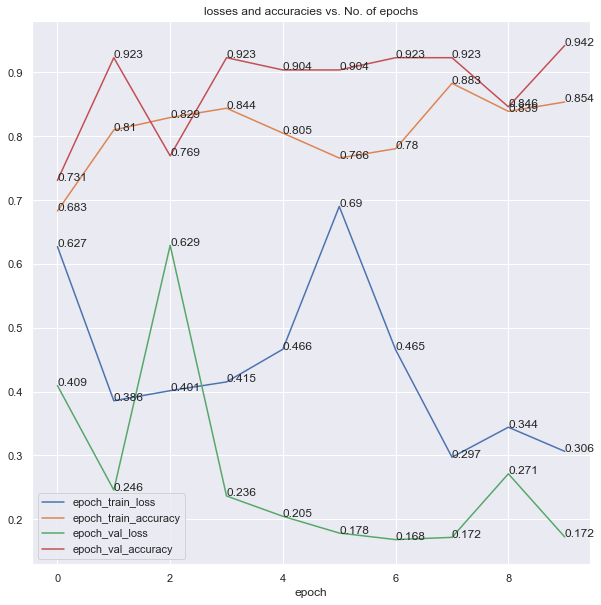

In [75]:
### plot all 4 across epoch:
plt.rcParams['figure.figsize'] = [10, 10]
def plot_accuracies(some_list, y_label):
    plt.plot(some_list, label=y_label)
    plt.xlabel('epoch')
    plt.title('losses and accuracies vs. No. of epochs');
    plt.legend(loc='lower left')

    # annotate graph
    for i in range(len(some_list)):
        plt.annotate(round(float(some_list[i]),3), (i,some_list[i]))
    
# path =  'models_trained/resnet18_hyphaAug4.pth'
# RESNET18
plot_accuracies(epoch_train_loss, 'epoch_train_loss')
plot_accuracies(epoch_val_loss, 'epoch_val_loss')
plot_accuracies(epoch_train_accuracy, 'epoch_train_accuracy')
plot_accuracies(epoch_val_accuracy, 'epoch_val_accuracy')

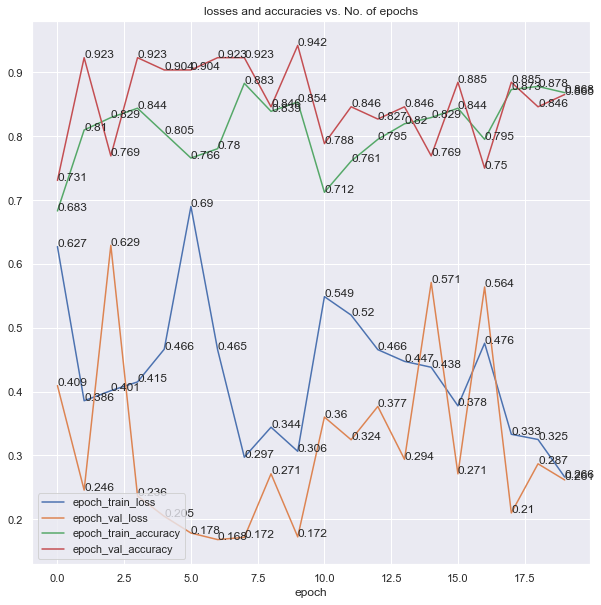

In [80]:
# RESNET50
# path =  'models_trained/resnet50_hyphaAug1.pth'
plot_accuracies(epoch_train_loss, 'epoch_train_loss')
plot_accuracies(epoch_val_loss, 'epoch_val_loss')
plot_accuracies(epoch_train_accuracy, 'epoch_train_accuracy')
plot_accuracies(epoch_val_accuracy, 'epoch_val_accuracy')

### Evaluation

In [86]:
## load model
path1 = 'models_trained/resnet18_hyphaAug4.pth'
path2 =  'models_trained/resnet50_hyphaAug1.pth'
loaded_model1 = torch.load(path1)
loaded_model2 = torch.load(path2)
loaded_model1.eval()
loaded_model2.eval()
# for param in loaded_model.parameters():
#     print(param)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [82]:
# evaluation
@torch.no_grad()
def get_all_preds(model, loader):
    # all_preds = torch.tensor([])
    all_preds = []
    all_labels = []
    for batch in loader:
        images, labels = batch
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        print(f"prediction: {preds}")
        print(f"labels: {labels}")
        for pred in preds:
            # print(pred)
            all_preds.append(pred.item())
        for label in labels:
            all_labels.append(label)
        
        # all_preds = torch.cat(
        #     (all_preds, preds)
        #     ,dim=0
        # )
        # all_preds = torch.cat(preds)
        # all_preds.append(preds)

        # print(all_preds)
        print(len(all_preds)) # 52 if using test dataloader
        print(len(all_labels))
        # break
    return all_preds, all_labels


prediction: tensor([1, 1, 1, 1])
labels: tensor([1, 0, 1, 1])
4
4
prediction: tensor([0, 1, 1, 1])
labels: tensor([0, 1, 1, 1])
8
8
prediction: tensor([1, 1, 0, 1])
labels: tensor([1, 1, 0, 0])
12
12
prediction: tensor([1, 0, 1, 1])
labels: tensor([1, 0, 1, 1])
16
16
prediction: tensor([0, 1, 1, 1])
labels: tensor([0, 1, 1, 1])
20
20
prediction: tensor([1, 0, 1, 1])
labels: tensor([1, 0, 1, 1])
24
24
prediction: tensor([1, 0, 1, 1])
labels: tensor([1, 0, 1, 1])
28
28
prediction: tensor([0, 1, 0, 1])
labels: tensor([0, 1, 0, 1])
32
32
prediction: tensor([1, 0, 1, 1])
labels: tensor([1, 0, 1, 1])
36
36
prediction: tensor([1, 1, 0, 1])
labels: tensor([1, 1, 0, 1])
40
40
prediction: tensor([0, 1, 1, 1])
labels: tensor([0, 1, 1, 1])
44
44
prediction: tensor([0, 0, 1, 1])
labels: tensor([0, 0, 1, 1])
48
48
prediction: tensor([1, 1, 1, 0])
labels: tensor([1, 0, 1, 0])
52
52
[[14  0]
 [ 3 35]]
[tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), t

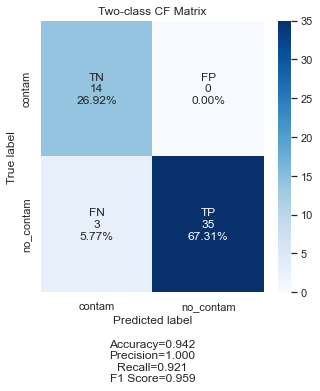

In [89]:
with torch.no_grad():
    # prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds, train_labels = get_all_preds(loaded_model1, dataloaders['test'])

cfm = confusion_matrix(train_preds, train_labels)
print(cfm)
labels = ['TN','FP','FN','TP']
print(train_labels)
sns.set(rc={'figure.figsize':(5,5)})
print(train_preds)
cf_matrix.make_confusion_matrix(cfm, group_names=labels, categories=class_names, cmap='Blues', title='Two-class CF Matrix')
# dk why these stats not showing in my matrix

if len(cfm)==2:
    # Metrics for Binary Confusion Matrices
    accuracy  = np.trace(cfm) / float(np.sum(cfm))
    print(np.trace(cfm) )
    print((float(np.sum(cfm))))
    precision = cfm[1,1] / sum(cfm[:,1])
    recall    = cfm[1,1] / sum(cfm[1,:])
    f1_score  = 2*precision*recall / (precision + recall)
    stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
        accuracy,precision,recall,f1_score)
print(stats_text)
plt.show()

prediction: tensor([1, 0, 1, 0])
labels: tensor([1, 0, 1, 0])
4
4
prediction: tensor([0, 1, 1, 0])
labels: tensor([0, 1, 1, 0])
8
8
prediction: tensor([1, 1, 1, 1])
labels: tensor([1, 1, 1, 0])
12
12
prediction: tensor([1, 1, 1, 0])
labels: tensor([1, 1, 1, 0])
16
16
prediction: tensor([0, 0, 0, 1])
labels: tensor([1, 0, 1, 1])
20
20
prediction: tensor([1, 0, 0, 1])
labels: tensor([1, 0, 0, 1])
24
24
prediction: tensor([1, 0, 0, 1])
labels: tensor([1, 0, 0, 1])
28
28
prediction: tensor([0, 1, 0, 0])
labels: tensor([1, 1, 0, 0])
32
32
prediction: tensor([1, 1, 1, 1])
labels: tensor([1, 1, 1, 1])
36
36
prediction: tensor([1, 1, 1, 1])
labels: tensor([1, 1, 1, 1])
40
40
prediction: tensor([1, 0, 0, 1])
labels: tensor([1, 0, 0, 1])
44
44
prediction: tensor([1, 1, 0, 0])
labels: tensor([1, 1, 0, 1])
48
48
prediction: tensor([0, 1, 1, 0])
labels: tensor([1, 1, 1, 0])
52
52
[[16  5]
 [ 1 30]]
[tensor(1), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), t

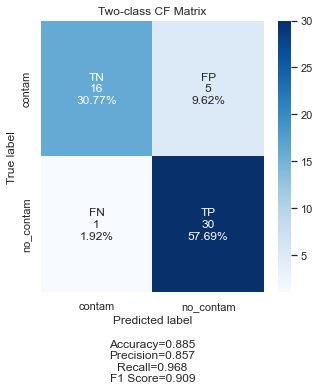

In [88]:
with torch.no_grad():
    # prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds, train_labels = get_all_preds(loaded_model2, dataloaders['test'])

cfm = confusion_matrix(train_preds, train_labels)
print(cfm)
labels = ['TN','FP','FN','TP']
print(train_labels)
sns.set(rc={'figure.figsize':(5,5)})
print(train_preds)
cf_matrix.make_confusion_matrix(cfm, group_names=labels, categories=class_names, cmap='Blues', title='Two-class CF Matrix')
# dk why these stats not showing in my matrix

if len(cfm)==2:
    # Metrics for Binary Confusion Matrices
    accuracy  = np.trace(cfm) / float(np.sum(cfm))
    print(np.trace(cfm) )
    print((float(np.sum(cfm))))
    precision = cfm[1,1] / sum(cfm[:,1])
    recall    = cfm[1,1] / sum(cfm[1,:])
    f1_score  = 2*precision*recall / (precision + recall)
    stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
        accuracy,precision,recall,f1_score)
print(stats_text)
plt.show()

### inference stuffs

In [ ]:
# def predict_image(img, model):
#     # Convert to a batch of 1
#     xb = img.unsqueeze(0), device
#     # Get predictions from model
#     yb = model(xb)
#     # Pick index with highest probability
#     _, preds  = torch.max(yb, dim=1)
#     # Retrieve the class label
#     return train_ds.classes[preds[0].item()]

In [113]:
# FOR 1 SINGLE SAMPLE
img, label = image_datasets['test'][45]
print(f"initial image shape: {img.shape} ")
print(f"label: {label} ")

# Convert to a batch of 1 to feed into the model properly
outputs = loaded_model1(img.unsqueeze(0))
_, pred = torch.max(outputs, 1)
print(pred)
class_predicted = class_names[pred]

initial image shape: torch.Size([3, 256, 256]) 
label: 1 
tensor([1])


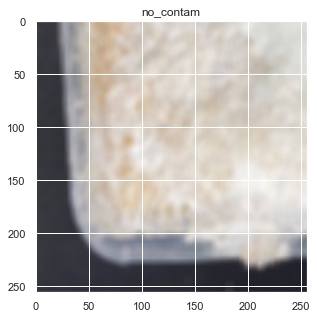

In [117]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Make a grid from batch(prob not required if single img)
out = torchvision.utils.make_grid(img)
imshow(out, class_predicted)